#### 获得地图数据

In [1]:
import json
import time
# 加载GeoJSON文件
with open('USA.geo.json', 'r') as f:
    geojson_data = json.load(f)

# 提取坐标
def extract_coordinates(geojson):
    coordinates = []
    if 'features' in geojson:
        for feature in geojson['features']:
            if 'geometry' in feature and 'coordinates' in feature['geometry']:
                coordinates.append(feature['geometry']['coordinates'])
    return coordinates

coordinates = extract_coordinates(geojson_data)


In [2]:
coord = coordinates[0]

In [3]:
map = coord[5][0]

In [4]:
map_int = [[int(value * 10) for value in sublist] for sublist in map]

#### 实现扫描线填充

In [5]:
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
import numpy as np
import math
import time

class AET:
    def __init__(self):
        self.x = 0
        self.delta = 0
        self.ymax = 0
        self.next = None
        self.rl = None

def fillIn(x, y, pointnum, ax):
    #找出最大值
    yymax = 0
    yymax = max(y)
    #建立新边表NET空间
    NET = {}
    #建立新边表
    for i in range(0, yymax):
        for j in range(0, pointnum):
            #找到每个点的y坐标
            if y[j] == i:
                if NET.get(i) == None:
                    NET[i] = AET()
                #这个点跟前面的一个点形成一条线段，跟后面的点也形成线段
                #存当前的x 到下一个点的detax 线段的最大y值
                if y[(j+1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j+1+pointnum)%pointnum]-x[j])/(y[(j+1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j+1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    AETpoint.rl = x[(j+1+pointnum)%pointnum]
                    NET[i].next = AETpoint
                if y[(j-1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j-1+pointnum)%pointnum]-x[j])/(y[(j-1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j-1+pointnum)%pointnum]
                    AETpoint.rl = x[(j-1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    NET[i].next = AETpoint

    # print(f"NET的长度{len(NET)}")
    #开始扫描

    del_time = 0
    draw_time = 0
    update_time = 0
    AETable = AET()
    for i in range(yymax):
        #删除扫描线已经到达ymax的点（顶点不画）
        #不把它插入到AET扫描序列中去
        q = AETable
        p = AETable.next
        start_time = time.time()
        while p!=None:
            if p.ymax == i:
                q.next = p.next
                del p
                p = q.next
            else:
                q = q.next
                p = p.next
        end_time = time.time()
        del_time += end_time - start_time
        if NET.get(i) != None:
            p = NET[i].next
        q = AETable
        while p!=None:
            while ((q.next!=None) and (p.x > q.next.x)) or ((q.next!=None) and (p.x == q.next.x) and q.next.rl < p.rl):
                q = q.next
            temp = p.next
            p.next = q.next
            q.next = p
            p = temp
            q = AETable
        #画图
        start_time = time.time()
        p = AETable.next
        while p!=None and p.next!=None:
            start = math.ceil(p.x)
            end = math.ceil(p.next.x)
            x_values = np.arange(start, end)
            ax.plot(x_values, np.full_like(x_values, i), 'r.')      
            p = p.next.next
        end_time = time.time()
        draw_time += end_time - start_time
        #改写像素值，为下一次扫描做准备
        start_time = time.time()
        p = AETable.next
        while p!=None:
            p.x = p.x + p.delta
            p = p.next
        end_time = time.time()

        update_time += end_time - start_time
    # print(f"删除节点时间总计:{del_time : .6f}\n画图时间总计:{draw_time : .6f}\n更新aet时间总计:{update_time : .6f}")




### 多边形简化算法

#### 道格拉斯算法实现

In [6]:

import math
from shapely import wkt, geometry
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
 
 
class Point:
    """点类"""
    x = 0.0
    y = 0.0
    index = 0  # 点在线上的索引
 
    def __init__(self, x, y, index):
        self.x = x
        self.y = y
        self.index = index
 
 
class Douglas:
    """道格拉斯算法类"""
    points = []
    D = 100  # 容差
 
    def readPoint(self, map = None):
        """生成点要素"""
        if map == None:
            g = [(1,4),(2,3),(3, 5),(4,2),(6,4),(8,4),(9,5),(12, 4),(15 ,8),(12, 10),(9, 9),(8, 10),(7, 8),(6, 11),(5, 12),(4, 10),(3, 11),(1, 4)]
        else:
            g = map
        for i in range(len(g)):
            self.points.append(Point(g[i][0], g[i][1], i))
 
    def compress(self, p1, p2):
        """具体的抽稀算法"""
        swichvalue = False


        # 一般式直线方程系数 A*x+B*y+C=0,利用点斜式,分母可以省略约区
        # A=(p1.y-p2.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        A = (p1.y - p2.y)
        # B=(p2.x-p1.x)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        B = (p2.x - p1.x)
        # C=(p1.x*p2.y-p2.x*p1.y)/math.sqrt(math.pow(p1.y-p2.y,2)+math.pow(p1.x-p2.x,2))
        C = (p1.x * p2.y - p2.x * p1.y)
 
        m = self.points.index(p1)
        n = self.points.index(p2)
        distance = {}
        middle = None
 
        if (n == m + 1):
            return
        # 计算中间点到直线的距离
        for i in range(m + 1, n):
            d = abs(A * self.points[i].x + B * self.points[i].y + C) / math.sqrt(math.pow(A, 2) + math.pow(B, 2))
            distance[i] = d
 
        dmax_index = max(distance, key=distance.get)
        dmax = distance[dmax_index]
 
        if dmax > self.D:
            swichvalue = True
        else:
            swichvalue = False
 
        if (not swichvalue):
            i = m+1
            while i != n:
                del self.points[i]
                n = n - 1
        else:
            middle = self.points[dmax_index]
            self.compress(p1, middle)
            self.compress(middle, p2)
 
    def printPoint(self):
        """打印数据点"""
        for p in self.points:
            print("%d,%f,%f" % (p.index, p.x, p.y))

#### Visvalingam-Whyatt算法实现

In [7]:
def visvalingam_whyatt(points, threshold):
    def triangle_area(p1, p2, p3):
        return abs((p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])) / 2.0)

    if len(points) < 3:
        return points

    simplified = [points[0], points[1]]

    for i in range(2, len(points)):
        area = triangle_area(simplified[-2], simplified[-1], points[i])
        if area > threshold:
            simplified.append(points[i])

    simplified.append(points[-1])
    return simplified

def plot_polygon(ax, points, color='blue'):
    x, y = zip(*points)
    ax.plot(x, y, color=color)
    ax.plot(x[0], y[0], color=color)  

#### 对地图多边形使用道格拉斯简化算法

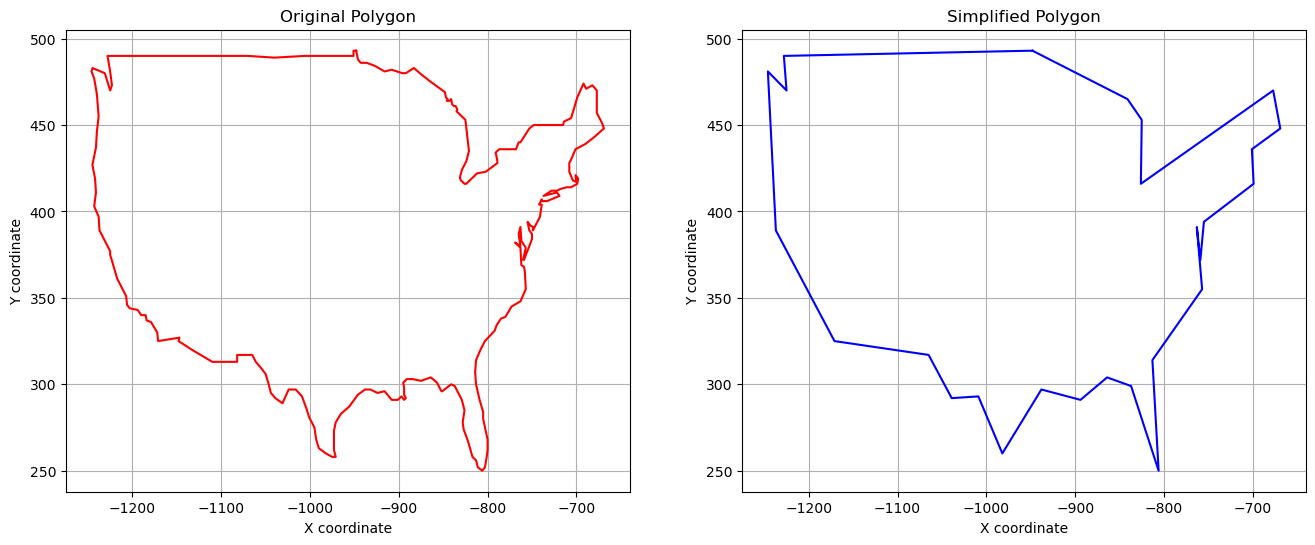

In [8]:

d = Douglas()
d.D = 10
d.readPoint(map=map_int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
dx = []
dy = []
for i in range(len(d.points)):
    dx.append(d.points[i].x)
    dy.append(d.points[i].y)
# ax1.plot(dx, dy, color='g', linestyle='-', marker='+')
points = [[x, y] for x, y in zip(dx, dy)]
plot_polygon(ax1, points, color='red')
ax1.set_title('Original Polygon')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.grid(True)
p1 = d.points[0] 
p2 = d.points[-2]
d.compress(p1, p2)

# 抽稀之后绘制
dx1 = []
dy1 = []
for p in d.points:
    dx1.append(p.x)
    dy1.append(p.y)
# ax2.plot(dx1, dy1, color='r', linestyle='-', marker='+')
simplified_points = [[x, y] for x, y in zip(dx1, dy1)]
plot_polygon(ax2, simplified_points, color='blue')
ax2.set_title('Simplified Polygon')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.grid(True)
 

plt.show()

In [9]:
print(f"原来的边数:{len(dx) - 1}\n简化后的边数:{len(dx1) - 1}")

原来的边数:232
简化后的边数:28


#### 分别测试原始图像的填充效果和简化后的图像的填充效果


填充时间: 0.241998


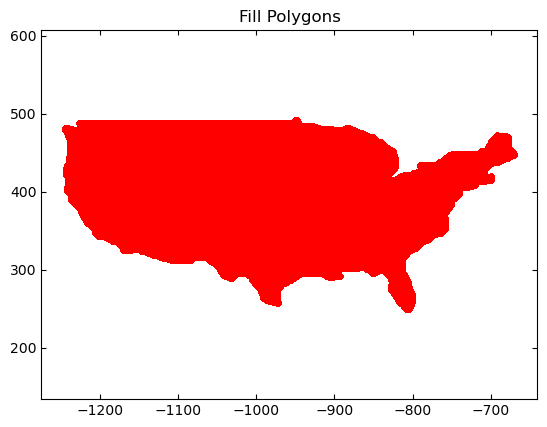

In [12]:
import time
#初始化图标设置
fig = plt.figure()
ax = axisartist.Subplot(fig, 111, title='Fill Polygons')  
fig.add_axes(ax)

#输入点数(顺着输)，画多边形
x = dx
# x.append(x[0])
y = dy
# y.append(y[0])
ax.plot(x, y)

#填充多边形
pointnum = len(x)
start_time = time.time()
for i in range(50):
    fillIn(x, y, pointnum, ax)
end_time = time.time()
print(f"填充时间:{(end_time - start_time) / 50 : .6f}")
plt.axis("equal")
plt.show()

填充时间: 0.204235


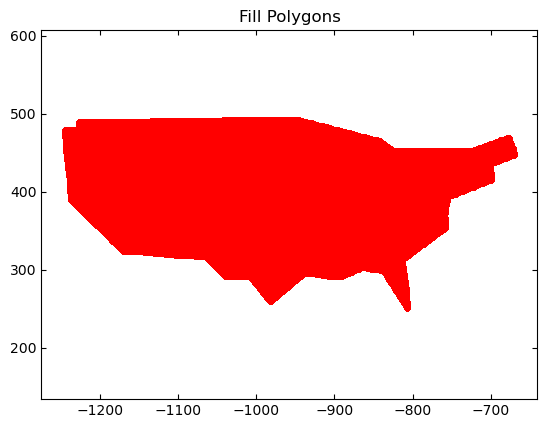

In [13]:

#初始化图标设置
fig = plt.figure()
ax = axisartist.Subplot(fig, 111, title='Fill Polygons');  
fig.add_axes(ax)

#输入点数(顺着输)，画多边形
x = dx1
# x.append(x[0])
y = dy1
# y.append(y[0])
ax.plot(x, y)

#填充多边形
pointnum = len(x)
start_time = time.time()
for i in range(50):
    fillIn(x, y, pointnum, ax)
end_time = time.time()
print(f"填充时间:{(end_time - start_time) / 50 : .6f}")
plt.axis("equal")
plt.show()

#### 对地图多边形使用Visvalingam-Whyatt算法简化后的效果

原来的顶点数:233
简化后的顶点数:134


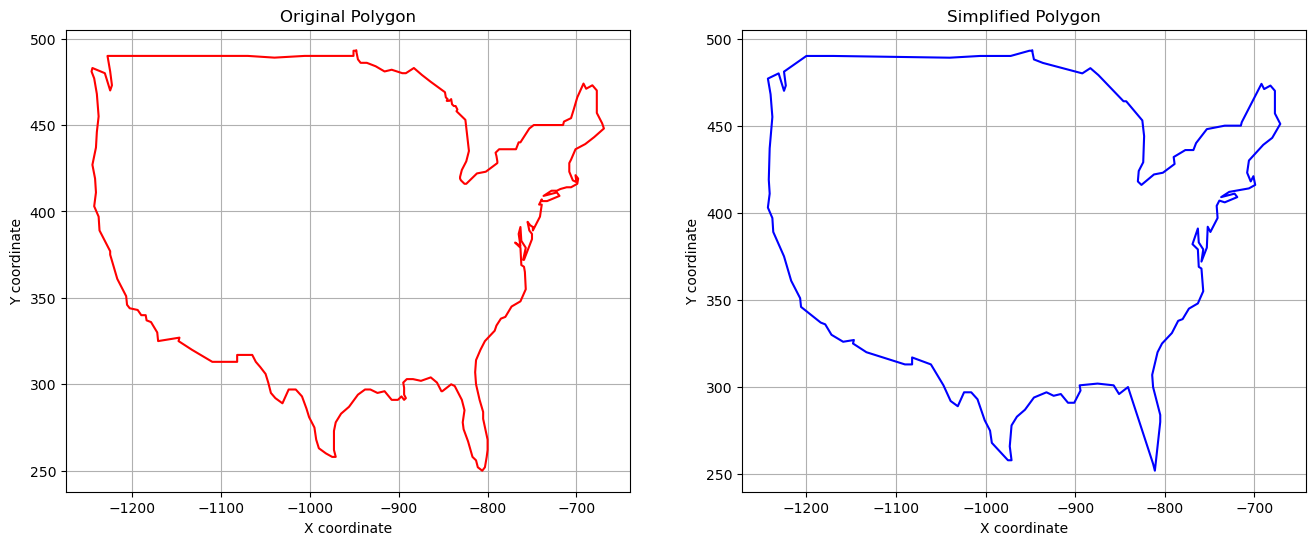

In [14]:

# Example usage
# points = [(1,4),(2,3),(3, 5),(4,2),(6,4),(8,4),(9,5),(12, 4),(15 ,8),(12, 10),(9, 9),(8, 10),(7, 8),(6, 11),(5, 12),(4, 10),(3, 11),(1, 4)]
points = map_int
threshold = 10
simplified_points = visvalingam_whyatt(points, threshold)
print(f"原来的顶点数:{len(points)}\n简化后的顶点数:{len(simplified_points)}")
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the original polygon
plot_polygon(ax1, points, color='red')
ax1.set_title('Original Polygon')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.grid(True)

# Plot the simplified polygon
plot_polygon(ax2, simplified_points, color='blue')
ax2.set_title('Simplified Polygon')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.grid(True)

plt.show()




#### 分别测试原始图像的填充效果和简化后的图像的填充效果


填充时间: 0.216623


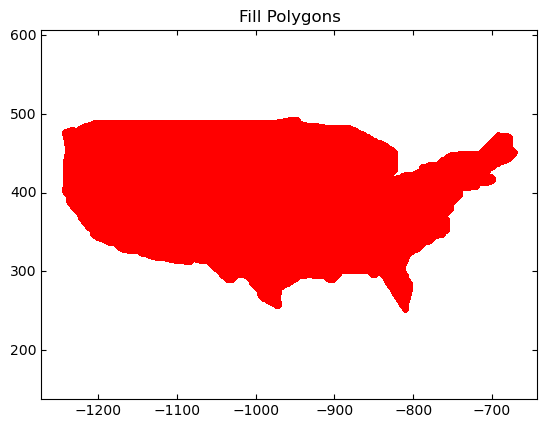

In [16]:
fig = plt.figure()
ax = axisartist.Subplot(fig, 111, title='Fill Polygons')  
fig.add_axes(ax)
x = [i[0] for i in simplified_points]

y = [i[1] for i in simplified_points]
ax.plot(x, y)

#填充多边形
pointnum = len(x)
start_time = time.time()
for i in range(50):
    fillIn(x, y, pointnum, ax)
end_time = time.time()
print(f"填充时间:{(end_time - start_time) / 50 : .6f}")
plt.axis("equal")
plt.show()

### 多边形分割算法

#### 三角剖分算法

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def is_convex(a, b, c):
    """ 检查由顶点 a, b, c 组成的角是否是凸的 """
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]) > 0

def is_point_in_triangle(p, a, b, c):
    """ 检查点 p 是否在三角形 a, b, c 内 """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    b1 = sign(p, a, b) < 0.0
    b2 = sign(p, b, c) < 0.0
    b3 = sign(p, c, a) < 0.0
    return ((b1 == b2) and (b2 == b3))

def is_ear(polygon, i):
    """ 检查多边形的某个顶点是否是一个耳 """
    prev_index = (i - 1) % len(polygon)
    next_index = (i + 1) % len(polygon)
    a, b, c = polygon[prev_index], polygon[i], polygon[next_index]

    if not is_convex(a, b, c):
        return False

    for j in range(len(polygon)):
        if j in (prev_index, i, next_index):
            continue
        if is_point_in_triangle(polygon[j], a, b, c):
            return False
    return True

def ear_clipping_triangulation(polygon):
    """ 使用耳切法对凹多边形进行三角剖分 """
    triangles = []
    polygon = polygon[:]
    while len(polygon) > 3:
        ear_found = False
        for i in range(len(polygon)):
            if is_ear(polygon, i):
                prev_index = (i - 1) % len(polygon)
                next_index = (i + 1) % len(polygon)
                triangles.append([polygon[prev_index], polygon[i], polygon[next_index]])
                del polygon[i]
                ear_found = True
                break
        if not ear_found:
            raise ValueError("没有找到耳，输入多边形可能是自交的")
    triangles.append(polygon)
    return triangles

def plot_polygon_triangulation(polygon, triangles):
    """ 绘制多边形及其三角剖分 """
    for triangle in triangles:
        t = np.array(triangle + [triangle[0]])  # 加上第一个点使其闭合
        plt.plot(t[:, 0], t[:, 1], 'k-')
    p = np.array(polygon + [polygon[0]])
    plt.plot(p[:, 0], p[:, 1], 'r--')
    plt.scatter(p[:, 0], p[:, 1], color='blue')
    plt.show()


#### 三角剖分算法效果

三角形个数:15


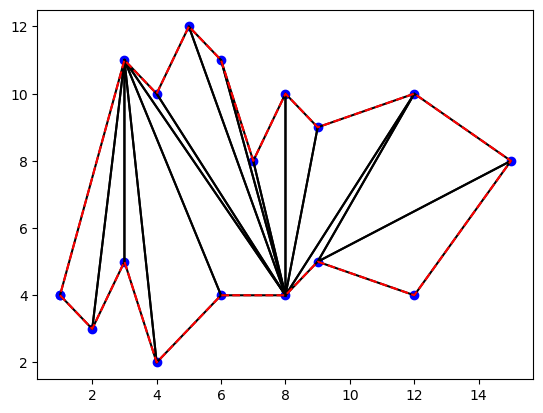

In [7]:
polygon = [(1,4),(2,3),(3, 5),(4,2),(6,4),(8,4),(9,5),(12, 4),(15 ,8),(12, 10),(9, 9),(8, 10),(7, 8),(6, 11),(5, 12),(4, 10),(3, 11)]

triangles = ear_clipping_triangulation(polygon)
print(f"三角形个数:{len(triangles)}")

# 绘制结果
plot_polygon_triangulation(polygon, triangles)


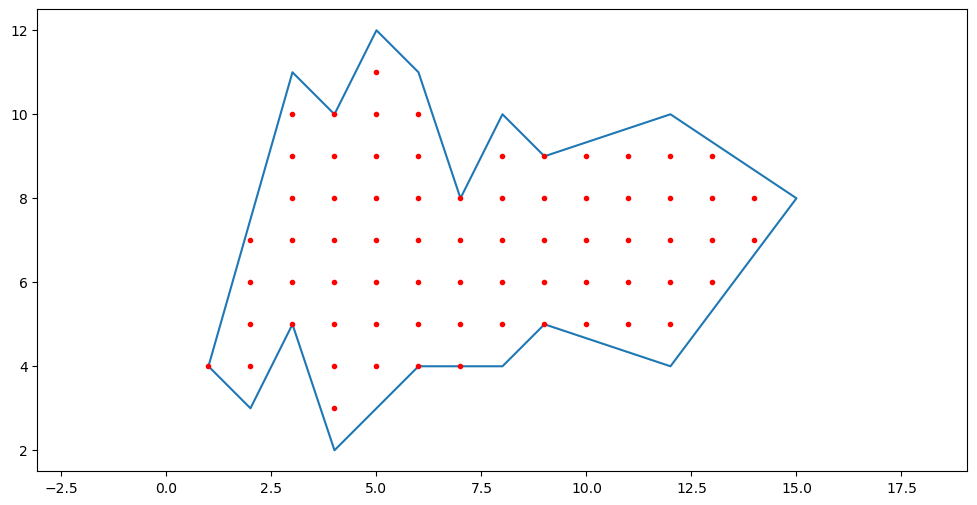

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

polygon.append(polygon[0])
x = [i[0] for i in polygon]

y = [i[1] for i in polygon]
ax.plot(x, y)

#填充多边形
pointnum = len(x)
fillIn(x, y, pointnum, ax)
# print(f"填充时间:{(end_time - start_time) / 50 : .6f}")
plt.axis("equal")
plt.show()

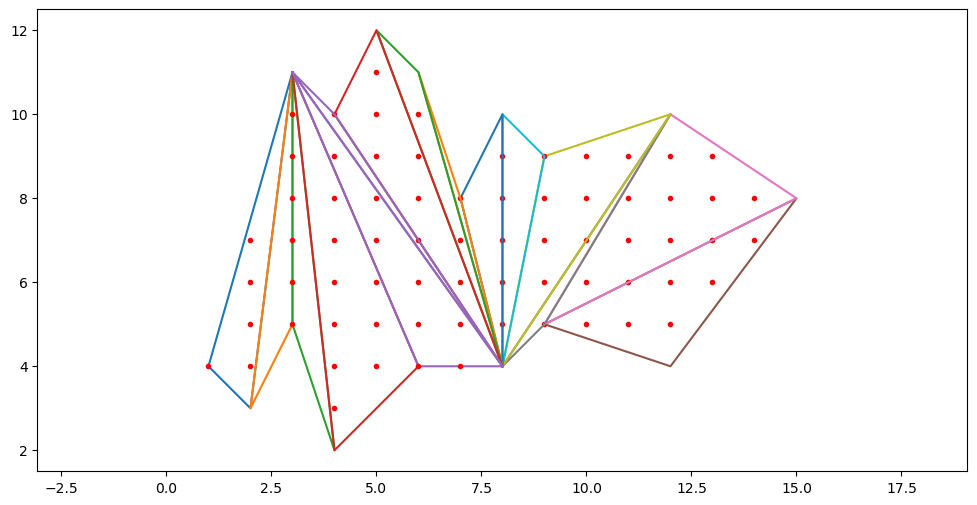

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

for tri in triangles:
    # 遍历每一个三角形

    x = [i[0] for i in tri]
    x.append(x[0])

    y = [i[1] for i in tri]
    y.append(y[0])
    ax.plot(x, y)

    #填充多边形
    pointnum = len(x)
    fillIn(x, y, pointnum, ax)
# print(f"填充时间:{(end_time - start_time) / 50 : .6f}")
plt.axis("equal")
plt.show()

#### 考虑填充时使用并行化

In [11]:
def fillIn2(x, y, pointnum):
    #找出最大值
    yymax = 0
    yymax = max(y)
    #建立新边表NET空间
    NET = {}
    #建立新边表
    for i in range(0, yymax):
        for j in range(0, pointnum):
            #找到每个点的y坐标
            if y[j] == i:
                if NET.get(i) == None:
                    NET[i] = AET()
                #这个点跟前面的一个点形成一条线段，跟后面的点也形成线段
                #存当前的x 到下一个点的detax 线段的最大y值
                if y[(j+1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j+1+pointnum)%pointnum]-x[j])/(y[(j+1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j+1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    AETpoint.rl = x[(j+1+pointnum)%pointnum]
                    NET[i].next = AETpoint
                if y[(j-1+pointnum)%pointnum] > y[j]:
                    AETpoint = AET()
                    AETpoint.x = x[j]
                    AETpoint.delta = (x[(j-1+pointnum)%pointnum]-x[j])/(y[(j-1+pointnum)%pointnum]-y[j])
                    AETpoint.ymax = y[(j-1+pointnum)%pointnum]
                    AETpoint.rl = x[(j-1+pointnum)%pointnum]
                    AETpoint.next = NET[i].next
                    NET[i].next = AETpoint

    x_list = list()
    y_list = list()
    AETable = AET()
    for i in range(yymax):
        #删除扫描线已经到达ymax的点（顶点不画）
        #不把它插入到AET扫描序列中去
        q = AETable
        p = AETable.next
        while p!=None:
            if p.ymax == i:
                q.next = p.next
                del p
                p = q.next
            else:
                q = q.next
                p = p.next
        if NET.get(i) != None:
            p = NET[i].next
        q = AETable
        while p!=None:
            while ((q.next!=None) and (p.x > q.next.x)) or ((q.next!=None) and (p.x == q.next.x) and q.next.rl < p.rl):
                q = q.next
            temp = p.next
            p.next = q.next
            q.next = p
            p = temp
            q = AETable
        #画图
        p = AETable.next
        while p!=None and p.next!=None:
            start = math.ceil(p.x)
            end = math.ceil(p.next.x)
            x_values = np.arange(start, end)
            x_list.append(x_values)
            y_list.append(i) 
            p = p.next.next
        #改写像素值，为下一次扫描做准备
        p = AETable.next
        while p!=None:
            p.x = p.x + p.delta
            p = p.next
        
    return x_list, y_list


填充时间: 1.585507


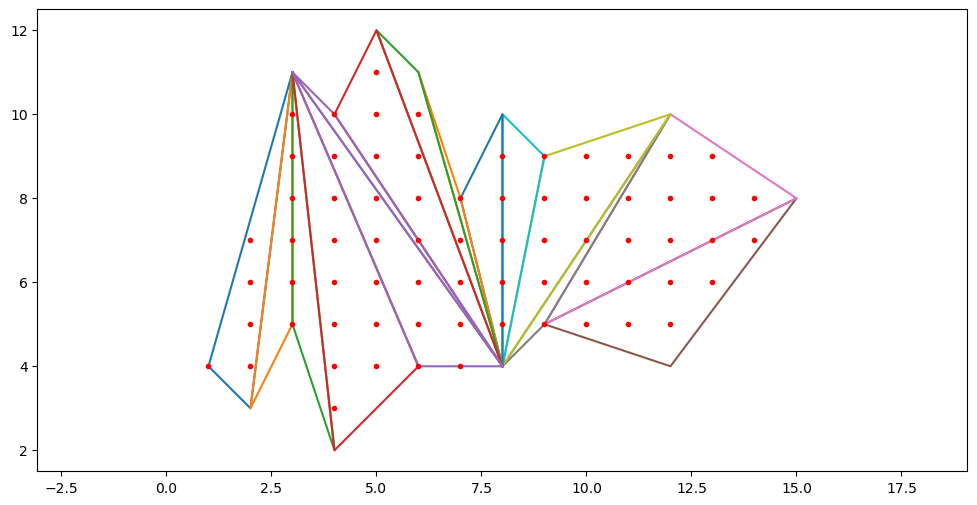

In [26]:
from concurrent.futures import ThreadPoolExecutor
fig, ax = plt.subplots(figsize=(12, 6))
for tri in triangles:
    x = [i[0] for i in tri]
    x.append(x[0])

    y = [i[1] for i in tri]
    y.append(y[0])
    ax.plot(x, y)

def draw_tri(tri):
    x = [i[0] for i in tri]
    x.append(x[0])

    y = [i[1] for i in tri]
    y.append(y[0])

    #填充多边形
    pointnum = len(x)
    return fillIn2(x, y, pointnum)

start_time = time.time()
for i in range(10):
    with ThreadPoolExecutor() as executor:
        results = executor.map(draw_tri, triangles)
end_time = time.time()
print(f"填充时间:{(end_time - start_time) / 10 * 1000 : .6f}")
for x, y in results:
    for i in range(len(x)):
        ax.plot(x[i], np.full_like(x[i], y[i]), 'r.')
plt.axis("equal")
plt.show()


填充时间: 19.574332


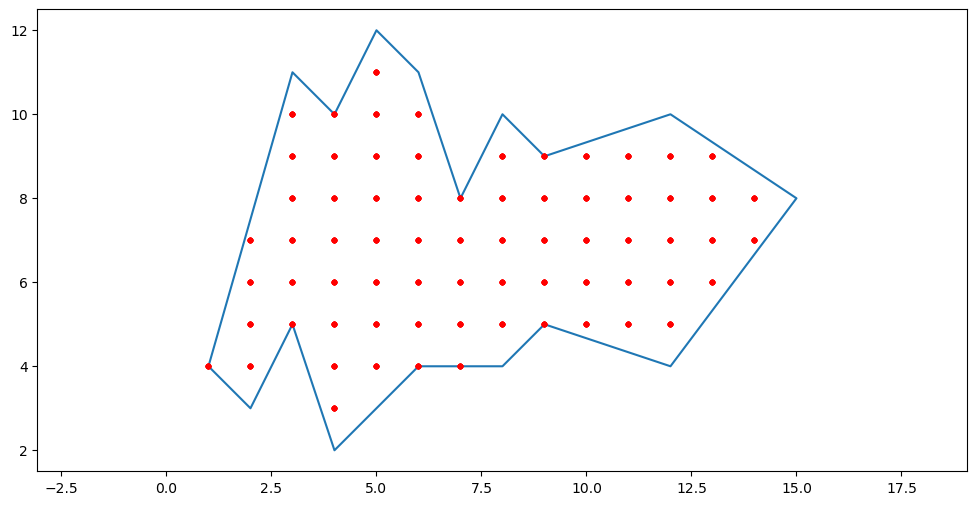

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

polygon.append(polygon[0])
x = [i[0] for i in polygon]

y = [i[1] for i in polygon]
ax.plot(x, y)

#填充多边形
pointnum = len(x)
start_time = time.time()
for i in range(10):
    fillIn(x, y, pointnum, ax)
end_time = time.time()
print(f"填充时间:{(end_time - start_time) / 10 * 1000 : .6f}")
plt.axis("equal")
plt.show()

### 多边形孔洞问题